# &#x1F4D1; &nbsp;  Digit Recognition Models #2
## Links
[SciPy. Multi-dimensional image processing](https://docs.scipy.org/doc/scipy/reference/ndimage.html)

[Keras. Deep Learning library for Theano and TensorFlow](https://keras.io/)
 
[TensorFlow. Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros) & [Tensorflow. Deep MNIST Advanced Tutorial](http://docs.seldon.io/tensorflow-deep-mnist-example.html)

[Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)
#### Other variants of this  project: [Digit Recognition Models](https://olgabelitskaya.github.io/kaggle_digits.html) & [Colaboratory Notebook](https://drive.google.com/open?id=1B1qh4ySXeJlWDMAXxAgHtS3jsyNdsmrn)
#### P5: Build a Digit Recognition Program: [1](https://olgabelitskaya.github.io/MLE_ND_P5_V0_S1.html) & [2](https://olgabelitskaya.github.io/MLE_ND_P5_V0_S2.html) & [3](https://olgabelitskaya.github.io/MLE_ND_P5_V0_S3.html)
## Libraries


In [1]:
import numpy as np,pandas as pd,pylab as pl
from time import time; from scipy import stats
import warnings; warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import label_propagation
from keras.utils import to_categorical
from keras.preprocessing import image as ksimage
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Sequential,Model
from keras.layers import Input,BatchNormalization,Flatten,Dropout
from keras.layers import Dense,LSTM,Activation,LeakyReLU,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPool2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import UpSampling2D,Conv2DTranspose,DepthwiseConv2D
from keras import __version__
print('keras version:', __version__)

Using TensorFlow backend.


keras version: 2.2.4


In [2]:
k=.48
wcnn='weights.best.digits.cnn.hdf5'
def hplot(history):
    pl.figure(figsize=(12,5))
    pl.plot(history.history['categorical_accuracy'][3:],'-o',label='train')
    pl.plot(history.history['val_categorical_accuracy'][3:],'-o',label='test')
    pl.legend(); pl.title('CNN Accuracy'); pl.show()
def top_3_categorical_accuracy(y_true,y_pred):
    return top_k_categorical_accuracy(y_true,y_pred,k=3)

## Datasets

In [3]:
df_train=pd.read_csv("../input/train.csv")
df_test=pd.read_csv("../input/test.csv")
print([df_train.shape,df_test.shape])
print(df_train.iloc[265,1:].values.reshape(28,28)[:,10])

[(42000, 785), (28000, 784)]
[  0   0   0   0   0   0   0   0  37 111 137 245 254 254 254 254  52   0
   0   0 186 254 163   0   0   0   0   0]


In [4]:
images=["%s%s"%("pixel",pixel_no) for pixel_no in range(0,784)]
train_images=np.array(df_train[images])
train_images=(train_images.astype('float32')/255)**k
train_labels=df_train['label']
train_labels_cat=to_categorical(train_labels,num_classes=10)
test_images=np.array(df_test[images])
test_images=(test_images.astype('float32')/255)**k
#train_images = (train_images.astype('float32')/255)
[train_images.shape,train_labels_cat.shape,test_images.shape]

[(42000, 784), (42000, 10), (28000, 784)]

In [5]:
X_train,X_test,y_train,y_test=\
train_test_split(train_images,train_labels_cat, 
                 test_size=.2,random_state=32)
n=int(len(X_test)/2)
X_valid,y_valid=X_test[:n],y_test[:n]
X_test,y_test=X_test[n:],y_test[n:]
y_train_num=np.array([np.argmax(x) for x in y_train])
y_test_num=np.array([np.argmax(x) for x in y_test])
y_valid_num=np.array([np.argmax(x) for x in y_valid])
[X_train.shape,X_test.shape,X_valid.shape,\
y_train.shape,y_test.shape,y_valid.shape]

[(33600, 784), (4200, 784), (4200, 784), (33600, 10), (4200, 10), (4200, 10)]

## Examples

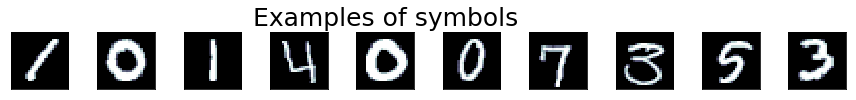

In [6]:
fig,ax=pl.subplots(figsize=(12,2),nrows=1,ncols=10,
                   sharex=True,sharey=True)
ax=ax.flatten()
for i in range(10):
    image=train_images[i].reshape(28,28)
    ax[i].imshow(image,cmap=pl.cm.bone)
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[4].set_title('Examples of symbols',fontsize=25)
pl.tight_layout(); pl.gcf(); pl.show()

## Models

In [7]:
# Model #1. Convolutional Neural Network. Keras
def cnn_model():
    model_input=Input(shape=(28,28,1))
    x=BatchNormalization()(model_input)    
    x=Conv2D(28,(5,5),padding='same')(x)
    x=LeakyReLU(alpha=.02)(x)
    x=MaxPooling2D(strides=(2,2))(x)
    x=Dropout(.25)(x)    
    x=Conv2D(96,(5,5))(x)
    x=LeakyReLU(alpha=.02)(x)
    x=MaxPooling2D(strides=(2,2))(x)
    x=Dropout(.25)(x) 
    x=GlobalMaxPooling2D()(x)    
    x=Dense(512)(x)
    x=LeakyReLU(alpha=.02)(x)
    x=Dropout(.5)(x)    
    y=Dense(10,activation='softmax')(x)    
    model=Model(input=model_input,output=y)    
    model.compile(loss='categorical_crossentropy',optimizer='nadam', 
                  metrics=[categorical_accuracy,top_3_categorical_accuracy])    
    return model
cnn_model=cnn_model()
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 28)        728       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)        67296     
__________

In [8]:
checkpointer=ModelCheckpoint(filepath=wcnn,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=2,factor=.8)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=cnn_model.fit(X_train.reshape(-1,28,28,1),y_train, 
                      validation_data=(X_valid.reshape(-1,28,28,1),y_valid), 
                      epochs=100,batch_size=128,verbose=2, 
                      callbacks=[checkpointer,lr_reduction,estopping])

Train on 33600 samples, validate on 4200 samples
Epoch 1/100
 - 7s - loss: 0.4355 - categorical_accuracy: 0.8578 - top_3_categorical_accuracy: 0.9440 - val_loss: 0.1429 - val_categorical_accuracy: 0.9536 - val_top_3_categorical_accuracy: 0.9943

Epoch 00001: val_loss improved from inf to 0.14295, saving model to weights.best.digits.cnn.hdf5
Epoch 2/100
 - 2s - loss: 0.1107 - categorical_accuracy: 0.9659 - top_3_categorical_accuracy: 0.9964 - val_loss: 0.0786 - val_categorical_accuracy: 0.9790 - val_top_3_categorical_accuracy: 0.9974

Epoch 00002: val_loss improved from 0.14295 to 0.07864, saving model to weights.best.digits.cnn.hdf5
Epoch 3/100
 - 2s - loss: 0.0829 - categorical_accuracy: 0.9752 - top_3_categorical_accuracy: 0.9973 - val_loss: 0.0594 - val_categorical_accuracy: 0.9831 - val_top_3_categorical_accuracy: 0.9974

Epoch 00003: val_loss improved from 0.07864 to 0.05942, saving model to weights.best.digits.cnn.hdf5
Epoch 4/100
 - 2s - loss: 0.0697 - categorical_accuracy: 0.97

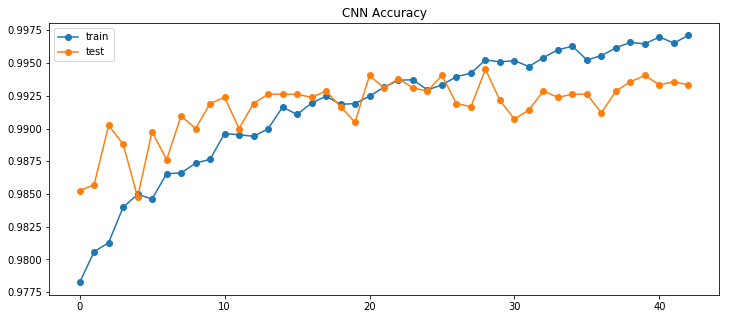

CNN Scores:  [0.02413942624428143, 0.9935714285714285, 0.9997619047619047]
CNN Error: 0.64%


In [9]:
cnn_model.load_weights(wcnn)
hplot(history)
scores=cnn_model.evaluate(X_test.reshape(-1,28,28,1),y_test,verbose=0)
print("CNN Scores: ",(scores))
print("CNN Error: %.2f%%"%(100-scores[1]*100))

In [10]:
steps,epochs=1000,10
data_generator=\
ImageDataGenerator(featurewise_std_normalization=True,
                   zoom_range=.2,shear_range=.2,rotation_range=30,
                   height_shift_range=.2,width_shift_range=.2)
history=cnn_model.\
fit_generator(data_generator.flow(X_train.reshape(-1,28,28,1),
                                  y_train,batch_size=128),
              steps_per_epoch=steps,epochs=epochs,verbose=2,
              validation_data=(X_valid.reshape(-1,28,28,1),y_valid), 
              callbacks=[checkpointer,lr_reduction,estopping])

Epoch 1/10
 - 34s - loss: 0.1792 - categorical_accuracy: 0.9444 - top_3_categorical_accuracy: 0.9918 - val_loss: 0.0321 - val_categorical_accuracy: 0.9917 - val_top_3_categorical_accuracy: 0.9990

Epoch 00001: val_loss did not improve from 0.02559
Epoch 2/10
 - 33s - loss: 0.1287 - categorical_accuracy: 0.9602 - top_3_categorical_accuracy: 0.9957 - val_loss: 0.0308 - val_categorical_accuracy: 0.9917 - val_top_3_categorical_accuracy: 0.9993

Epoch 00002: val_loss did not improve from 0.02559
Epoch 3/10
 - 32s - loss: 0.1122 - categorical_accuracy: 0.9648 - top_3_categorical_accuracy: 0.9964 - val_loss: 0.0284 - val_categorical_accuracy: 0.9929 - val_top_3_categorical_accuracy: 0.9993

Epoch 00003: val_loss did not improve from 0.02559
Epoch 4/10
 - 33s - loss: 0.1043 - categorical_accuracy: 0.9677 - top_3_categorical_accuracy: 0.9964 - val_loss: 0.0309 - val_categorical_accuracy: 0.9919 - val_top_3_categorical_accuracy: 0.9988

Epoch 00004: val_loss did not improve from 0.02559
Epoch 5/

In [11]:
cnn_model.load_weights(wcnn)
scores=cnn_model.evaluate(X_test.reshape(-1,28,28,1),y_test,verbose=0)
print("CNN Scores: ",(scores))
print("CNN Error: %.2f%%"%(100-scores[1]*100))

CNN Scores:  [0.02413942624428143, 0.9935714285714285, 0.9997619047619047]
CNN Error: 0.64%


In [12]:
Model #2. Multi-layer Perceptron. Keras
def mlp_model():
    model=Sequential()    
    model.add(Dense(784,activation='relu',input_shape=(784,)))
    model.add(Dropout(.25))
    model.add(Dense(392,activation='relu'))
    model.add(Dropout(.25))   
    model.add(Dense(196,activation='relu'))
    model.add(Dropout(.25))    
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='nadam',loss='categorical_crossentropy', 
                  metrics=[categorical_accuracy,top_3_categorical_accuracy])
    return model
mlp_model=mlp_model()

In [13]:
checkpointer=ModelCheckpoint(filepath=wcnn,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=mlp_model.fit(X_train,y_train,validation_data=(X_valid,y_valid), 
                     epochs=100,batch_size=128,verbose=2,
                     callbacks=[checkpointer,lr_reduction,estopping])

Train on 33600 samples, validate on 4200 samples
Epoch 1/100
 - 2s - loss: 0.3339 - categorical_accuracy: 0.8960 - top_3_categorical_accuracy: 0.9727 - val_loss: 0.2043 - val_categorical_accuracy: 0.9369 - val_top_3_categorical_accuracy: 0.9905

Epoch 00001: val_loss improved from inf to 0.20426, saving model to weights.best.digits.cnn.hdf5
Epoch 2/100
 - 1s - loss: 0.1473 - categorical_accuracy: 0.9545 - top_3_categorical_accuracy: 0.9937 - val_loss: 0.1326 - val_categorical_accuracy: 0.9617 - val_top_3_categorical_accuracy: 0.9955

Epoch 00002: val_loss improved from 0.20426 to 0.13264, saving model to weights.best.digits.cnn.hdf5
Epoch 3/100
 - 1s - loss: 0.1102 - categorical_accuracy: 0.9664 - top_3_categorical_accuracy: 0.9964 - val_loss: 0.1036 - val_categorical_accuracy: 0.9683 - val_top_3_categorical_accuracy: 0.9981

Epoch 00003: val_loss improved from 0.13264 to 0.10363, saving model to weights.best.digits.cnn.hdf5
Epoch 4/100
 - 1s - loss: 0.0911 - categorical_accuracy: 0.97

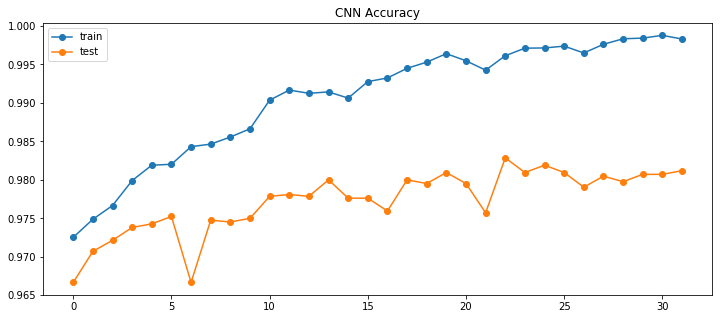

4200/4200 [==============================] - 0s 59us/step

MLP Scores:  [0.09600476235233275, 0.9835714285714285, 0.9983333333333333]
MLP Error: 1.64%


In [14]:
hplot(history)
scores=mlp_model.evaluate(X_test,y_test)
print("\nMLP Scores: ",(scores))
print("MLP Error: %.2f%%"%(100-scores[1]*100))

In [15]:
# Model #3. Recurrent Neural Network. Keras
def rnn_model():
    model=Sequential()
    model.add(LSTM(196,return_sequences=True,input_shape=(1,784)))    
    model.add(LSTM(196,return_sequences=True))    
    model.add(LSTM(196))      
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='nadam', 
                  metrics=[categorical_accuracy,top_3_categorical_accuracy])    
    return model
rnn_model=rnn_model()

In [16]:
checkpointer=ModelCheckpoint(filepath=wcnn,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=rnn_model.fit(X_train.reshape(-1,1,X_train.shape[1]),y_train, 
                      epochs=100,batch_size=128,verbose=2, 
                      validation_data=(X_valid.reshape(-1,1,X_valid.shape[1]),y_valid),
                      callbacks=[checkpointer,lr_reduction,estopping])

Train on 33600 samples, validate on 4200 samples
Epoch 1/100
 - 6s - loss: 0.3583 - categorical_accuracy: 0.8941 - top_3_categorical_accuracy: 0.9732 - val_loss: 0.2490 - val_categorical_accuracy: 0.9207 - val_top_3_categorical_accuracy: 0.9929

Epoch 00001: val_loss improved from inf to 0.24901, saving model to weights.best.digits.cnn.hdf5
Epoch 2/100
 - 4s - loss: 0.1220 - categorical_accuracy: 0.9629 - top_3_categorical_accuracy: 0.9956 - val_loss: 0.1208 - val_categorical_accuracy: 0.9633 - val_top_3_categorical_accuracy: 0.9962

Epoch 00002: val_loss improved from 0.24901 to 0.12084, saving model to weights.best.digits.cnn.hdf5
Epoch 3/100
 - 4s - loss: 0.0779 - categorical_accuracy: 0.9754 - top_3_categorical_accuracy: 0.9976 - val_loss: 0.1089 - val_categorical_accuracy: 0.9655 - val_top_3_categorical_accuracy: 0.9976

Epoch 00003: val_loss improved from 0.12084 to 0.10889, saving model to weights.best.digits.cnn.hdf5
Epoch 4/100
 - 4s - loss: 0.0555 - categorical_accuracy: 0.98

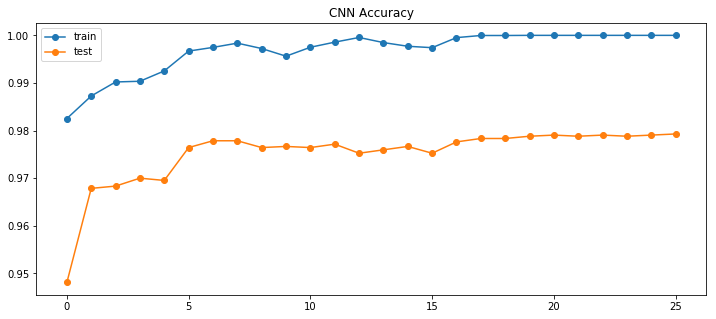

4200/4200 [==============================] - 1s 157us/step

RNN Scores:  [0.07498752159731382, 0.9842857142857143, 0.9985714285714286]
RNN Error: 1.57%


In [17]:
hplot(history)
scores=rnn_model.evaluate(X_test.reshape(-1,1,X_test.shape[1]),y_test)
print("\nRNN Scores: ",(scores))
print("RNN Error: %.2f%%"%(100-scores[1]*100))

In [18]:
# Model #4. MLPClassifier. Scikit-learn
n_total=7000; X2=np.copy(X_train[:n_total])
y2=np.copy(y_train_num[:n_total]).astype('int64')
clf=MLPClassifier(hidden_layer_sizes=(784,),max_iter=100,alpha=1e-4,
                  solver='lbfgs',verbose=1,tol=1e-6,random_state=1,
                  learning_rate_init=7e-4,batch_size=128)
clf.fit(X2,y2)
print("MNIST. MLPClassifier. Train score: %f"%(clf.score(X2,y2)*100),'%')
print("MNIST. MLPClassifier. Test score: %f"%(clf.score(X_test,y_test_num)*100),'%')

MNIST. MLPClassifier. Train score: 100.000000 %
MNIST. MLPClassifier. Test score: 95.285714 %


In [19]:
# Model #5. LabelSpreading. Scikit-learn
n_total=5000; n_labeled=4000
X2=np.copy(X_train[:n_total])
y2=np.copy(y_train_num[:n_total]).astype('int64')
y2[n_labeled:]=-1
lp_model=label_propagation\
         .LabelSpreading(kernel='knn',n_neighbors=10,max_iter=20)
lp_model.fit(X2,y2)
predicted_labels=lp_model.transduction_[n_labeled:n_total]
true_labels=y_train_num[n_labeled:n_total]
print('Label Spreading: %d labeled & %d unlabeled points (%d total)'%
      (n_labeled,n_total-n_labeled,n_total))
print(classification_report(true_labels,predicted_labels))
print('Confusion matrix')
print(confusion_matrix(true_labels,predicted_labels,
                       labels=lp_model.classes_))
predict_entropies=\
stats.distributions.entropy(lp_model.label_distributions_.T)
uncertainty_index=np.argsort(predict_entropies)[-10:]

Label Spreading: 4000 labeled & 1000 unlabeled points (5000 total)
             precision    recall  f1-score   support

          0       0.97      0.96      0.96        93
          1       0.89      1.00      0.94        99
          2       0.98      0.88      0.93        93
          3       0.92      0.94      0.93       122
          4       0.98      0.93      0.95        96
          5       0.97      0.87      0.92        85
          6       0.96      0.98      0.97       120
          7       0.93      0.96      0.94       115
          8       0.91      0.92      0.91        73
          9       0.93      0.95      0.94       104

avg / total       0.94      0.94      0.94      1000

Confusion matrix
[[ 89   0   0   0   0   0   2   0   2   0]
 [  0  99   0   0   0   0   0   0   0   0]
 [  1   2  82   3   0   0   0   4   1   0]
 [  0   0   2 115   0   1   0   2   2   0]
 [  1   2   0   0  89   0   0   0   0   4]
 [  0   2   0   4   0  74   2   1   1   1]
 [  1   1   0   0  

## Predictions

In [20]:
predict_labels=cnn_model.predict(test_images.reshape(-1,28,28,1))
predict_labels=predict_labels.argmax(axis=-1)

In [21]:
submission=pd.DataFrame({"ImageId":range(1,len(predict_labels)+1), 
                         "Label":predict_labels})
print(submission[0:10])
submission.to_csv('kaggle_digits_cnn.csv',index=False)

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3


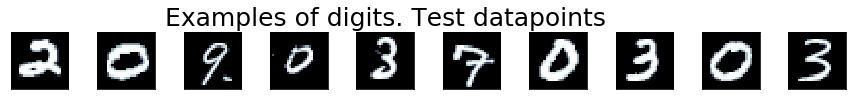

In [22]:
fig,ax=pl.subplots(figsize=(12,2),nrows=1,ncols=10,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(10):
    image=test_images[i].reshape(28,28)
    ax[i].imshow(image,cmap=pl.cm.bone)
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[4].set_title('Examples of digits. Test datapoints',fontsize=25)
pl.tight_layout(); pl.gcf(); pl.show()